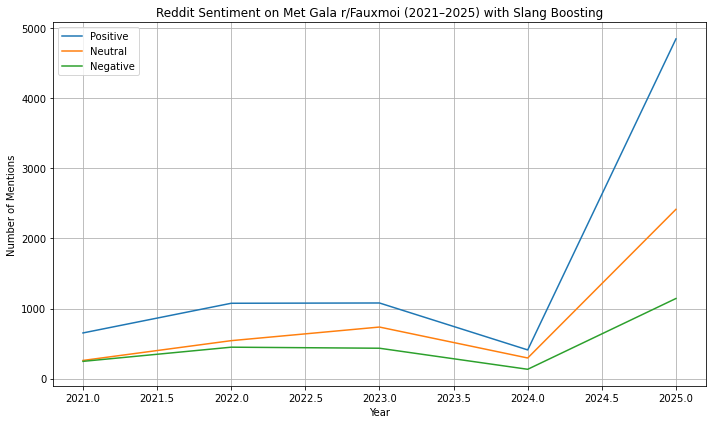

In [86]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Custom slang dictionaries
modern_positive_slang = {
    'slay': 3.0, 'fire': 3.0, 'lit': 2.5, 'queen': 2.5, 'iconic': 2.7, 'goals': 2.5, 'stan': 3.0,
    'vibe': 1.5, 'periodt': 2.5, 'glowing': 2.0, 'obsessed': 2.5, "chef's kiss": 3.0,
    'serve': 2.5, 'ate': 3.0, 'baddie': 2.5, 'snatched': 2.5, 'yas': 2.5, 'slaps': 2.0,
    'bop': 2.0, 'glow up': 2.5, 'goated': 3.0, 'wig': 2.5, 'flex': 1.5, 'lowkey': 0.5,
    'highkey': 1.5, 'drop': 1.0,
}

modern_negative_slang = {
    'basic': -1.5, 'mid': -2.0, 'cringe': -2.5, 'yikes': -2.0, 'boomer': -1.5, 'karen': -2.5,
    'trash': -3.0, 'flop': -2.5, 'cancelled': -2.5, 'sus': -1.5, 'drama': -1.5, 'ghost': -2.0,
    'toxic': -3.0, 'triggered': -1.5, 'gaslighting': -3.0, 'problematic': -2.0, 'fell off': -2.0,
    'fumbled': -2.0, 'cap': -1.5, 'pressed': -1.5, 'brutal': -2.0, 'tea': -1.0, 'shade': -1.5,
    'fake': -2.0, 'dead': -0.5,
}

def adjust_score_for_slang(text, base_score):
    score = base_score
    text = text.lower()
    for word, value in modern_positive_slang.items():
        if word in text:
            score += value * 0.1  # Tune multiplier as needed
    for word, value in modern_negative_slang.items():
        if word in text:
            score += value * 0.1
    return max(min(score, 1.0), -1.0)  # Clamp between -1 and 1

# Sentiment pipeline
analyzer = SentimentIntensityAnalyzer()
folder = "metgala_data_cleaned"
years = [2021, 2022, 2023, 2024, 2025]
sentiment_summary = []

for year in years:
    filepath = os.path.join(folder, f"metgala_Fauxmoi_{year}.json")
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    for post in data:
        post_text = post.get("title", "") + " " + post.get("selftext", "")
        sentiment = analyzer.polarity_scores(post_text)
        sentiment["compound"] = adjust_score_for_slang(post_text, sentiment["compound"])
        sentiment["type"] = "post"
        sentiment["year"] = year
        sentiment_summary.append(sentiment)

        for comment in post.get("comments", []):
            comment_text = comment.get("body", "")
            sentiment = analyzer.polarity_scores(comment_text)
            sentiment["compound"] = adjust_score_for_slang(comment_text, sentiment["compound"])
            sentiment["type"] = "comment"
            sentiment["year"] = year
            sentiment_summary.append(sentiment)

# Create DataFrame
df_sentiments = pd.DataFrame(sentiment_summary)

# Labeling function
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_sentiments["sentiment_label"] = df_sentiments["compound"].apply(label_sentiment)

# Plotting
plt.figure(figsize=(10, 6))
for label in ["Positive", "Neutral", "Negative"]:
    yearly_counts = df_sentiments[df_sentiments["sentiment_label"] == label]["year"].value_counts().sort_index()
    plt.plot(yearly_counts.index, yearly_counts.values, label=label)

plt.title("Reddit Sentiment on Met Gala r/Fauxmoi (2021–2025) with Slang Boosting")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


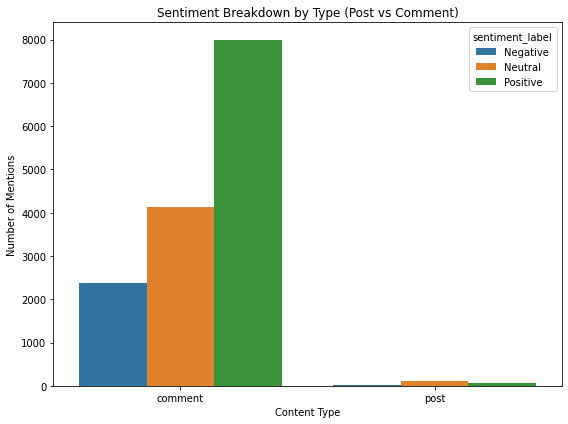

In [87]:
import seaborn as sns

# Count sentiment labels by type
type_sentiment_counts = df_sentiments.groupby(["type", "sentiment_label"]).size().reset_index(name="count")

# Barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=type_sentiment_counts, x="type", y="count", hue="sentiment_label")
plt.title("Sentiment Breakdown by Type (Post vs Comment)")
plt.xlabel("Content Type")
plt.ylabel("Number of Mentions")
plt.tight_layout()
plt.show()


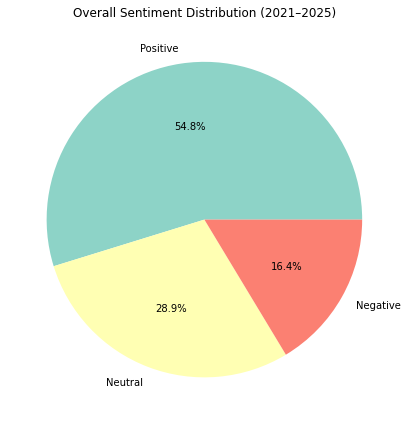

In [88]:
# Pie chart of all sentiment labels
sentiment_counts = df_sentiments["sentiment_label"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct="%1.1f%%", colors=["#8dd3c7", "#ffffb3", "#fb8072"])
plt.title("Overall Sentiment Distribution (2021–2025)")
plt.tight_layout()
plt.show()


In [89]:
import os
import json
import pandas as pd

def extract_sentiment_from_reddit(path, year):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    records = []

    for post in data:
        post_id = post.get("id", "")
        post_author = post.get("author", "unknown")
        post_text = post.get("title", "") + " " + post.get("selftext", "")
        score = analyzer.polarity_scores(post_text)['compound']
        records.append({
            "type": "post",
            "year": year,
            "text": post_text,
            "sentiment": score,
            "author": post_author
        })

        for comment in post.get("comments", []):
            comment_author = comment.get("author", "unknown")
            comment_text = comment.get("body", "")
            if comment_text.strip() == "":
                continue
            score = analyzer.polarity_scores(comment_text)['compound']
            records.append({
                "type": "comment",
                "year": year,
                "text": comment_text,
                "sentiment": score,
                "author": comment_author
            })

    return pd.DataFrame(records)


In [109]:
years = [ 2022, 2023, 2024, 2025]
all_data = []

for year in years:
    fauxmoi_path = f"metgala_data_cleaned/metgala_Fauxmoi_{year}.json"
    popchat_path = f"metgala_data_cleaned/metgala_popculturechat_{year}.json"

    df_fauxmoi = extract_sentiment_from_reddit(fauxmoi_path, year)
    df_fauxmoi['subreddit'] = "Fauxmoi"

    df_popchat = extract_sentiment_from_reddit(popchat_path, year)
    df_popchat['subreddit'] = "PopCultureChat"

    all_data.append(df_fauxmoi)
    all_data.append(df_popchat)

sentiment_df = pd.concat(all_data)
# Lowercase celeb names for matching
all_celebs = set(name.lower() for names in top_celebs_by_year.values() for name in names)

# Add a column for matched celeb name
def detect_mentioned_celebs(text):
    mentions = [celeb for celeb in all_celebs if celeb in text.lower()]
    return mentions[0] if mentions else None

sentiment_df['mentioned_celebs'] = sentiment_df['text'].apply(detect_mentioned_celebs)


In [110]:
exploded = sentiment_df.copy()


In [111]:
print(exploded.columns)


Index(['type', 'year', 'text', 'sentiment', 'author', 'subreddit',
       'mentioned_celebs'],
      dtype='object')


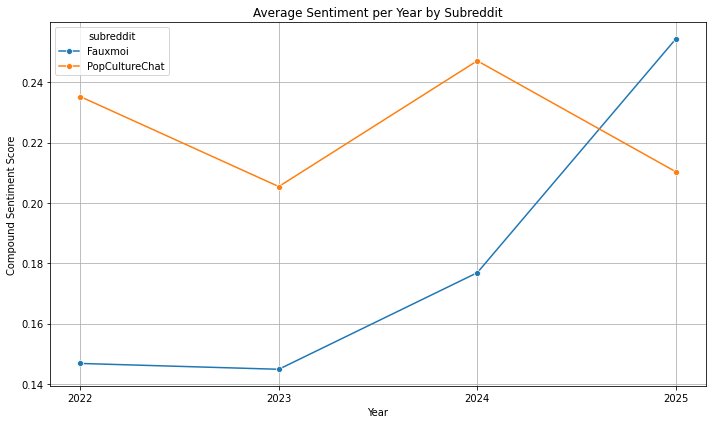

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

avg_sentiment['year'] = avg_sentiment['year'].astype(int)

plt.figure(figsize=(10,6))
sns.lineplot(data=avg_sentiment, x="year", y="sentiment", hue="subreddit", marker="o")

plt.title("Average Sentiment per Year by Subreddit")
plt.xlabel("Year")
plt.ylabel("Compound Sentiment Score")
plt.xticks(avg_sentiment['year'].unique())  # Ensure clean year ticks
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
def get_sentiment_summary(df, celeb_name, year):
    filtered = df[
        (df['mentioned_celebs'] == celeb_name.lower()) & 
        (df['year'] == year)
    ]

    if filtered.empty:
        return None

    avg_score = round(filtered['sentiment'].mean(), 3)
    pos = filtered[filtered['sentiment'] > 0.7].sort_values(by='sentiment', ascending=False).head(1)
    neg = filtered[filtered['sentiment'] < -0.5].sort_values(by='sentiment').head(1)

    pos_quote = pos['text'].values[0] if not pos.empty else "N/A"
    neg_quote = neg['text'].values[0] if not neg.empty else "N/A"

    return {
        'Mentions': len(filtered),
        'Avg Sentiment': avg_score,
        'Top Positive Quote': pos_quote,
        'Top Negative Quote': neg_quote
    }


In [114]:
top_celebs_by_year = {
    2021: ['Zendaya', 'Kim Kardashian', 'Lil Nas X', 'AOC', 'Billie Eilish'],
    2022: ['Blake Lively', 'Ryan Reynolds', 'Rihanna', 'Doja Cat', 'Kim Kardashian'],
    2023: ['Doja Cat', 'Lil Nas X', 'Rihanna', 'Kim Kardashian', 'Bad Bunny'],
    2024: ['Zendaya', 'J.Lo', 'Kim Kardashian', 'Doja Cat', 'Cardi B'],
    2025: ['Zendaya', 'Doechii', 'Rihanna', 'Anna Wintour', 'Diana Ross']
}


In [115]:
summary_rows = []

for year, celeb_list in top_celebs_by_year.items():
    for celeb in celeb_list:
        result = get_sentiment_summary(exploded, celeb, year)
        if result:
            summary_rows.append({
                'Year': year,
                'Celebrity': celeb,
                'Mentions': result['Mentions'],
                'Avg Sentiment': result['Avg Sentiment'],
                'Top Positive Quote': result['Top Positive Quote'][:300],  
                'Top Negative Quote': result['Top Negative Quote'][:300]
            })


In [116]:
df_all_sentiment = pd.DataFrame(summary_rows)


In [117]:
df_all_sentiment[df_all_sentiment['Year'] == 2025]  


,Year,Celebrity,Mentions,Avg Sentiment,Top Positive Quote,Top Negative Quote
12,2025,Zendaya,371,0.361,okay okay couple question knowledge ba 1 venue...,personal conspiracy theory something went wron...
13,2025,Doechii,114,0.175,doechii met look breakdown lot history slavery...,really think it’s starting become apparent doe...
14,2025,Rihanna,94,0.233,i’m honestly confused they’re affording unders...,people saying normally would celeb she’s fucki...
15,2025,Anna Wintour,46,0.175,don’t know it’s true i’m sure read somewhere a...,said dont think usher would associate abusive ...
16,2025,Diana Ross,57,0.229,people might call boring tailored perfection l...,stupid thought diana ross one daughter tracee ...


In [118]:
df_all_sentiment[df_all_sentiment['Year'] == 2024]  

,Year,Celebrity,Mentions,Avg Sentiment,Top Positive Quote,Top Negative Quote
8,2024,Zendaya,202,0.286,given jlo’s fashion responsible creation googl...,think zendaya come top especially chair year l...
9,2024,Kim Kardashian,18,0.312,didn’t say single thing alia bhatt talking dre...,know fake one industry problem kanye lol even ...
10,2024,Doja Cat,10,0.003,oh come really dont think nudity matter yall s...,doja cat always give girl high school 2002 a50...
11,2024,Cardi B,27,0.170,please dont downvote oblivion cardi b evolved ...,mean im also marketing still rude maintaining ...


In [119]:
df_all_sentiment[df_all_sentiment['Year'] == 2023]  

,Year,Celebrity,Mentions,Avg Sentiment,Top Positive Quote,Top Negative Quote
4,2023,Doja Cat,26,0.257,knowing nothing karl lagerfeld make fun laugh ...,N/A
5,2023,Rihanna,133,0.159,knew rita os circle friend london she’s actual...,load material people turning late reason didnt...
6,2023,Kim Kardashian,13,0.152,think theme really interesting potential readi...,suspect cosmetic refreshing done face look unf...
7,2023,Bad Bunny,15,-0.280,N/A,uhm first time i’ve ever seen bad bunny’s outf...


In [120]:
df_all_sentiment[df_all_sentiment['Year'] == 2022]  

,Year,Celebrity,Mentions,Avg Sentiment,Top Positive Quote,Top Negative Quote
0,2022,Blake Lively,31,0.631,please help need normal fact blake lively hi h...,also term negative go wedding ryan real planta...
1,2022,Ryan Reynolds,15,0.774,grown part brain say terrible idea advising sa...,N/A
2,2022,Rihanna,18,0.272,mean rihanna involved comme de garcons look tu...,taylor rihanna beyoncé know andre leon talley ...
3,2022,Kim Kardashian,15,-0.074,y’all it’s piece old fabric ripley’s benefited...,marilyn monroe iconic dress badly damaged kim ...


In [102]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_topic_wordclouds(lda_model, vectorizer, n_topics=6):
    feature_names = vectorizer.get_feature_names_out()
    
    for idx, topic in enumerate(lda_model.components_):
        top_features = {
            feature_names[i]: topic[i] 
            for i in topic.argsort()[:-30:-1]  # Top 30 words
        }
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_features)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {idx}", fontsize=14)
        plt.tight_layout()
        plt.show()


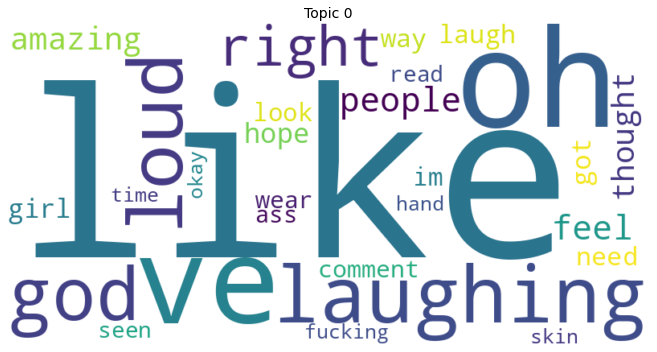

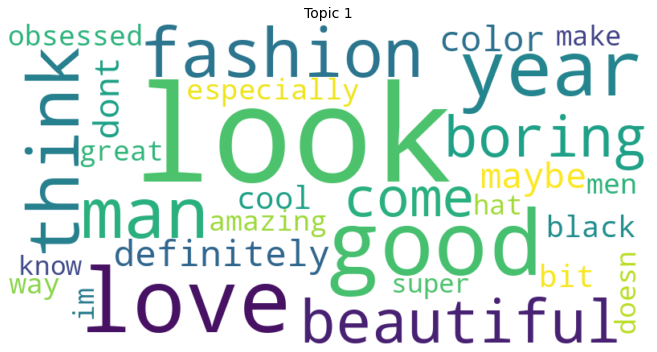

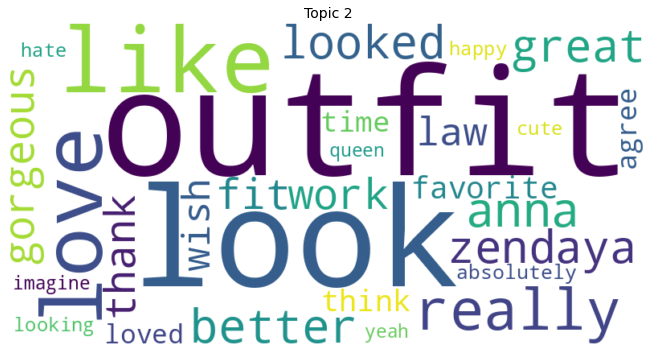

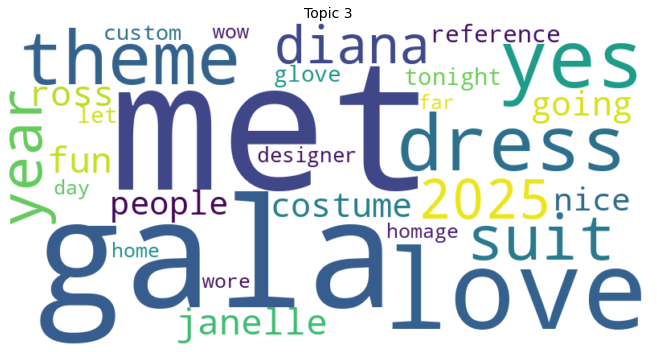

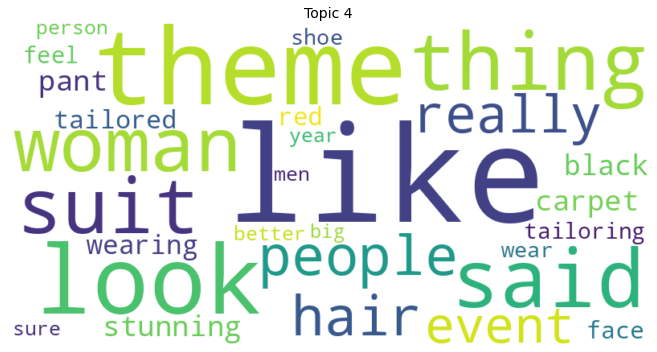

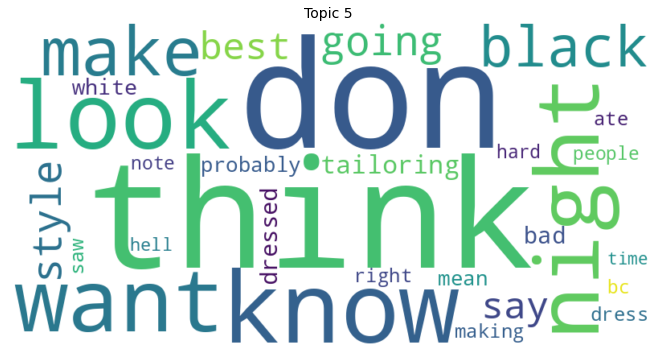

In [103]:
plot_topic_wordclouds(faux_lda, faux_vectorizer)


In [104]:
import networkx as nx

def load_user_community_mapping(graph_file):
    G = nx.read_graphml(graph_file)
    # Ensure node labels are strings (usernames)
    return {str(node): data.get("community") for node, data in G.nodes(data=True)}


In [105]:
def assign_communities(df, graph_file, subreddit_name):
    user_community = load_user_community_mapping(graph_file)
    df = df[(df['year'] == 2025) & (df['subreddit'].str.lower() == subreddit_name.lower())].copy()
    df['community'] = df['author'].map(user_community)
    return df.dropna(subset=['community'])  # Drop rows with unmapped users


In [106]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def topic_model_subreddit(df, n_topics=6):
    df['text'] = df['text'].fillna('').str.lower()
    vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=10)
    X = vectorizer.fit_transform(df['text'])

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_matrix = lda.fit_transform(X)

    df['dominant_topic'] = topic_matrix.argmax(axis=1)
    return df, lda, vectorizer


In [107]:
def topic_vs_community(df):
    summary = df.groupby(['community', 'dominant_topic']).size().unstack(fill_value=0)
    return summary.div(summary.sum(axis=1), axis=0)  # normalize


In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_topic_heatmap(topic_df, subreddit):
    plt.figure(figsize=(10, 6))
    sns.heatmap(topic_df, annot=True, cmap="YlOrRd", fmt=".2f")
    plt.title(f"Topic Distribution by Community – {subreddit} (2025)")
    plt.xlabel("Topic")
    plt.ylabel("Community")
    plt.tight_layout()
    plt.show()


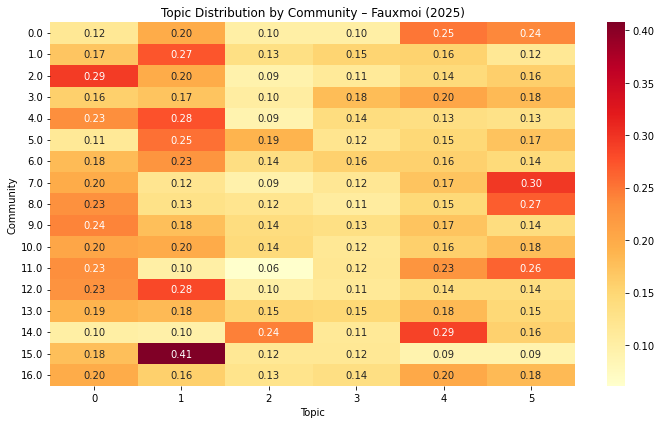

In [65]:
faux_df = assign_communities(exploded, "fauxmoi_2025_community.graphml", "fauxmoi")
faux_df_topics, faux_lda, faux_vectorizer = topic_model_subreddit(faux_df, n_topics=6)
faux_topic_distribution = topic_vs_community(faux_df_topics)
plot_topic_heatmap(faux_topic_distribution, "Fauxmoi")


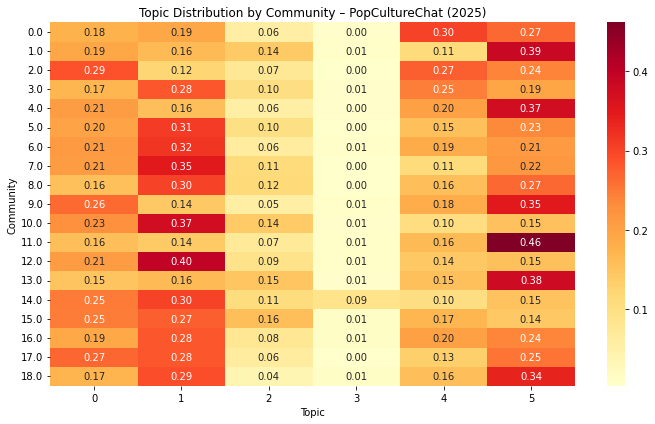

In [67]:
pop_df = assign_communities(exploded, "popculturechat_2025_community.graphml", "popculturechat")
pop_df_topics, pop_lda, pop_vectorizer = topic_model_subreddit(pop_df, n_topics=6)
pop_topic_distribution = topic_vs_community(pop_df_topics)
plot_topic_heatmap(pop_topic_distribution, "PopCultureChat")


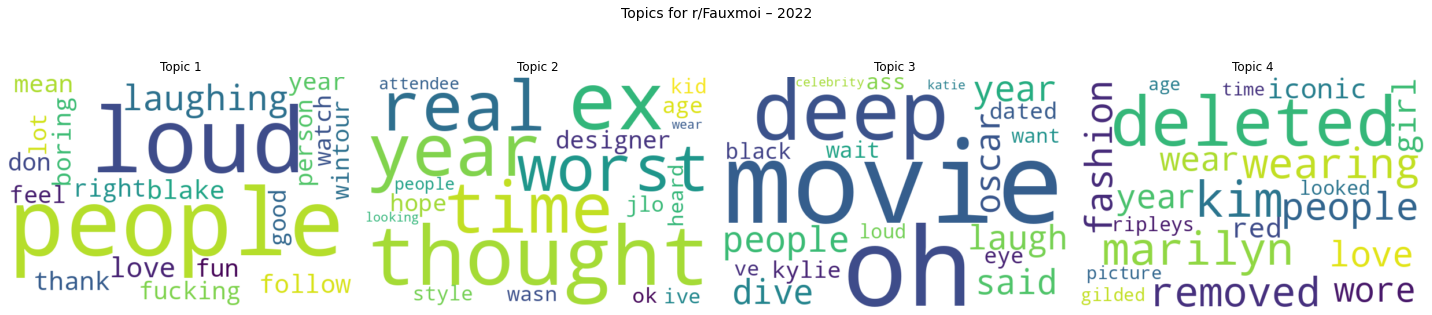

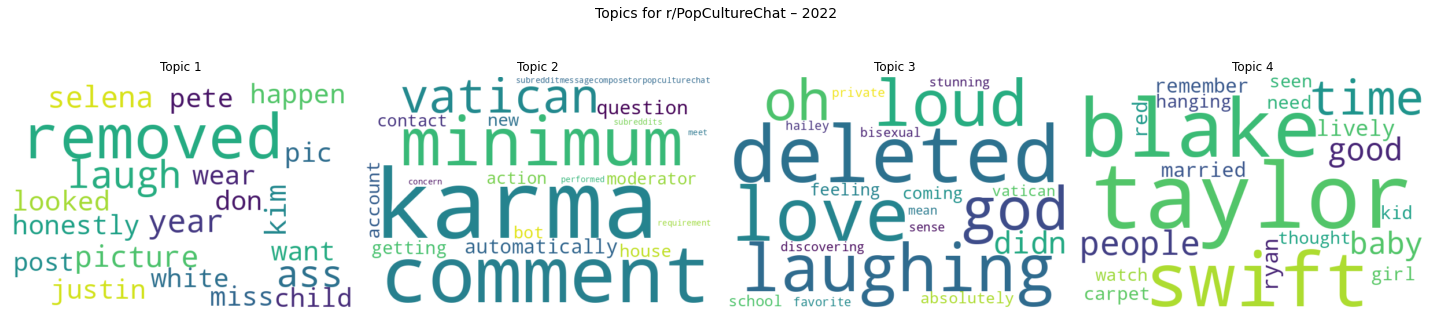

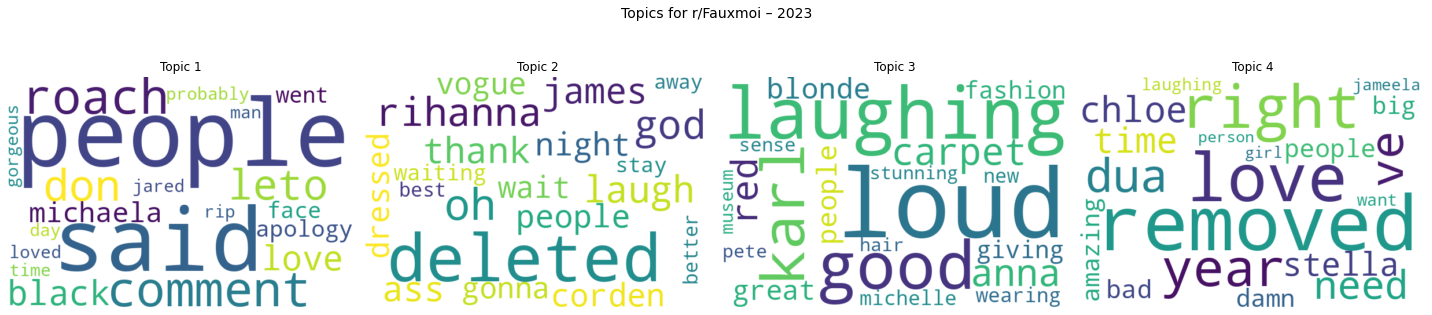

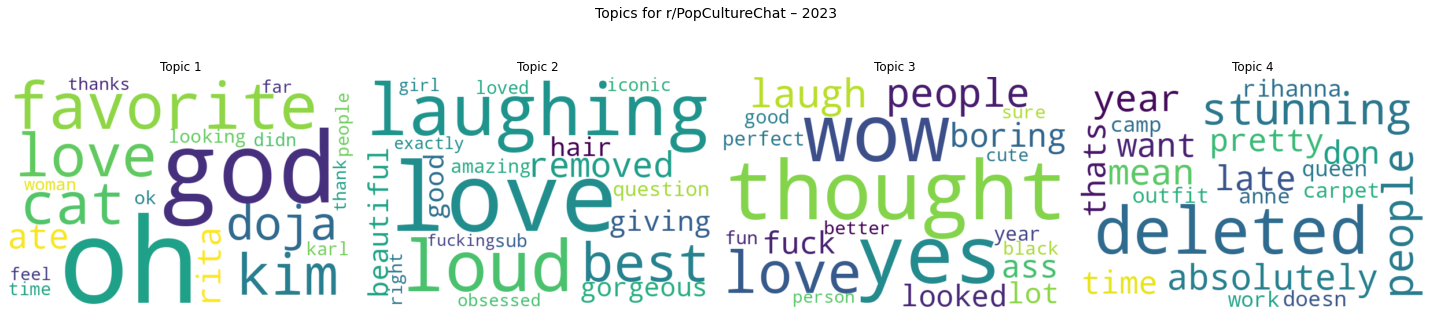

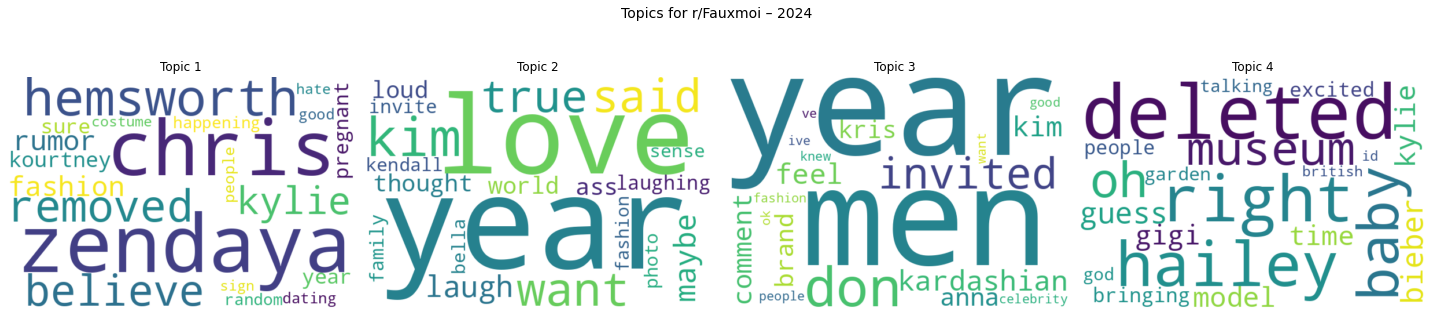

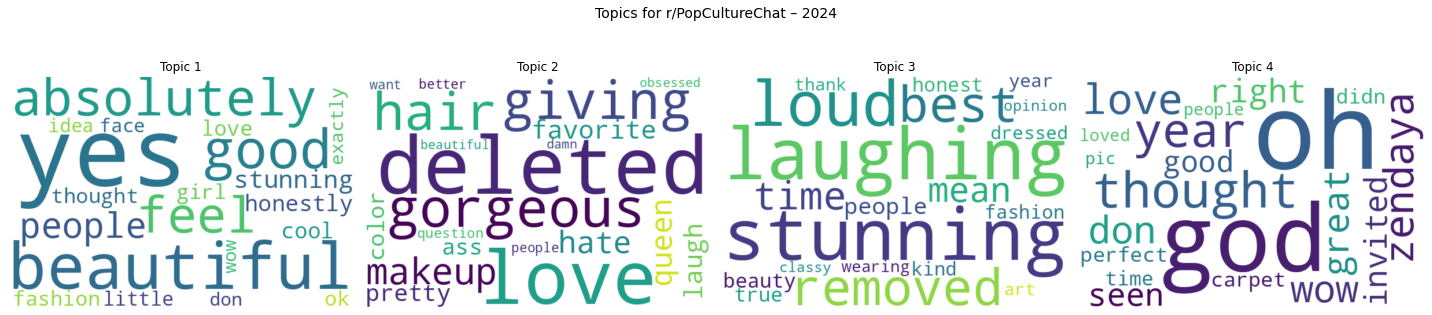

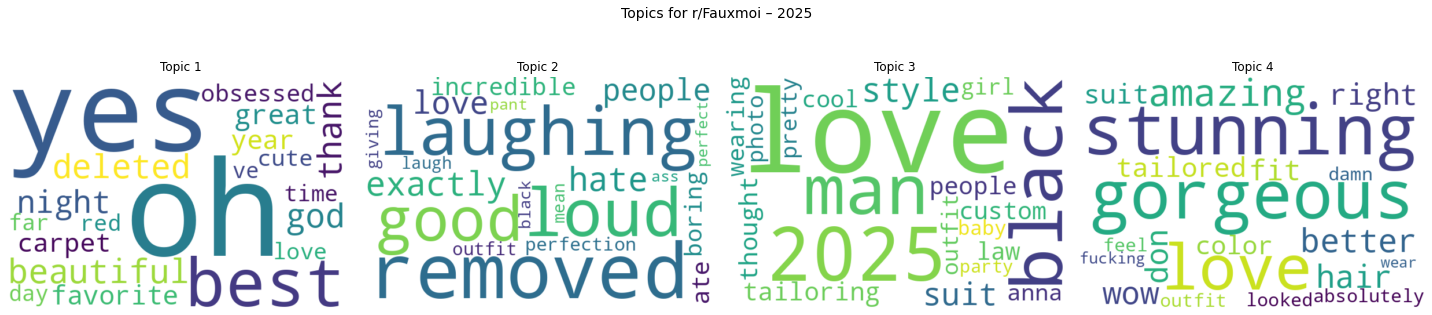

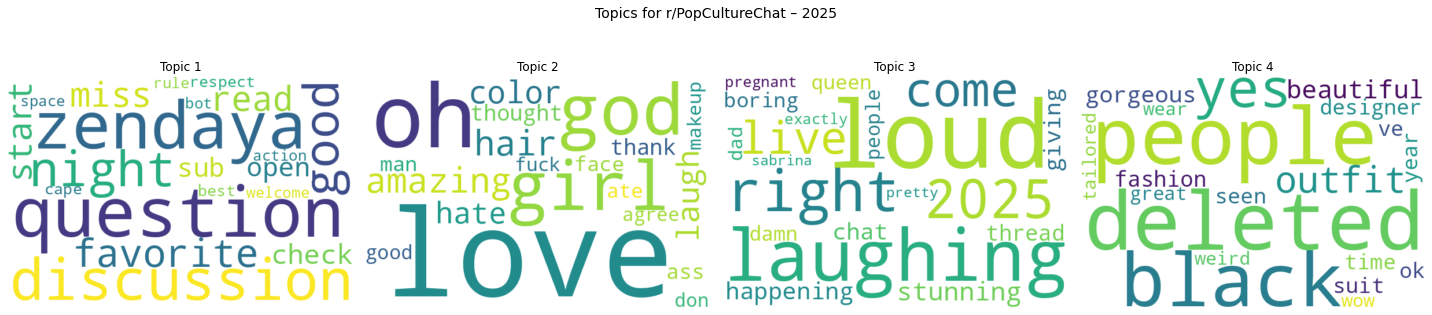

In [85]:
 import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
from wordcloud import WordCloud

# Config
data_folder = "metgala_data_cleaned"
years = [2022, 2023, 2024, 2025]
subreddits = ["Fauxmoi", "PopCultureChat"]
n_topics = 4
min_df_threshold = 3  # to remove super rare words

# Custom stopwords
custom_stopwords = text.ENGLISH_STOP_WORDS.union([
    'like', 'just', 'really', 'actually', 'literally', 'lol', 'omg',
    'okay', 'yeah', 'im', 'dont', 'didnt', 'doesnt', 'hes', 'shes',
    'theyre', 'youre', 'we', 'thing', 'stuff', 'say', 'get', 'got',
    'someone', 'something', 'make', 'made', 'one', 'look', 'looks',
    'going', 'know', 'think', 'way', 'met', 'gala', 'theme', 'dress'
])

# Function to load all texts for a given year and subreddit
def load_year_subreddit_data(year, subreddit):
    filename = f"metgala_{subreddit}_{year}.json"
    path = os.path.join(data_folder, filename)
    if not os.path.exists(path):
        print(f"Missing: {filename}")
        return []

    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    texts = []
    for post in raw:
        texts.append((post.get("title", "") or "") + " " + (post.get("selftext", "") or ""))
        for comment in post.get("comments", []):
            texts.append((comment.get("body", "") or ""))
    return [t.lower() for t in texts if t.strip()]

# Run LDA with TF-IDF weighting
def run_lda_tfidf_wordcloud(docs, year, subreddit, n_topics=4, min_df=3):
    if len(docs) < n_topics:
        print(f"Skipping {year} {subreddit} due to insufficient documents.")
        return

    vectorizer = TfidfVectorizer(
        stop_words=list(custom_stopwords),
        max_df=0.95,
        min_df=min_df
    )
    tfidf_matrix = vectorizer.fit_transform(docs)
    if tfidf_matrix.shape[0] < n_topics:
        print(f"Skipping {year} {subreddit} — not enough topic diversity.")
        return

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)

    vocab = vectorizer.get_feature_names_out()

    # Generate wordclouds
    fig, axes = plt.subplots(1, n_topics, figsize=(20, 5))
    for idx, topic_weights in enumerate(lda.components_):
        topic_words = {vocab[i]: topic_weights[i] for i in topic_weights.argsort()[-20:]}
        wc = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(topic_words)
        axes[idx].imshow(wc, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f"Topic {idx+1}", fontsize=12)
    plt.suptitle(f"Topics for r/{subreddit} – {year}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run for all years and subreddits
for year in years:
    for sub in subreddits:
        docs = load_year_subreddit_data(year, sub)
        run_lda_tfidf_wordcloud(docs, year, sub, n_topics=n_topics, min_df=min_df_threshold)
